In [1]:
!pwd
import sys
import os
path = os.getcwd()
path += '/../../'
sys.path.append(path)

import starburst
from starburst import utils
from starburst import sweep

import log_jobs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import time 
import copy 
from collections import OrderedDict 
import math
import heapq
import re
from IPython.display import display
import itertools
import pickle
pd.set_option('display.max_columns', None)

/home/surya/starburst/starburst/plots


In [2]:
INSTANCE_GPUS = {
    "n2-standard-2": 0
}

INSTANCE_CPUS = {
    "n2-standard-2": 2
}

GCP_PRICES = {
    "unknown": 0.038795,
    "n2-standard-2": 0.112452,
    "e2-medium": 0.038795,
    "e2-standard-8": 0.31036,
    "n1-standard-96": 4.56 
}

VMS = {
    "1689102776.9346955": 1, # CPU Sleep
    "1689124195.684018": 1, 
}

logs =  "1689102776.9346955"

In [3]:
# TODO (surya): Check for ground truth  -- Compare the datapoints from parse_job_df to ensure there are no missing jobs 
# TODO (surya): Support both GPU and CPU (e.g. "workload_type")

class Data:
    def __init__(self, data_dict):
        self.__dict__.update(data_dict)

# TODO: Generalize the rest of the ipynb to work with different versions of parse_job_df for different logging services
# TODO: Parse the correct job arrival time
def parse_job_df(cluster_event_df=None, submission_df=None, sweep_df=None, columns=None, run_id=None, cloud_log_list=None):
    # Split up input dictionary and initialize data structures
    types = ['onprem', 'cloud']
    onprem_event_df = cluster_event_df['onprem']
    cloud_event_df = cluster_event_df['cloud']
    hyperparameters = sweep_df[0]
    
    metadata = {'missing_jobs':[]}
    job_names = {}
    jobs = {}
    for col in columns: 
        jobs[col] = []

    all_nodes = set()
    nodes = {}
    nodes_indices = {}
    node_counter = 0
    
    for cluster_type in types: 
        event_df = cluster_event_df[cluster_type]
        try:
            job_times = {}
            pod_times = {}
            
            if cluster_type == 'cloud':
                # Parse cloud log files
                for job in cloud_log_list[1:-1]:
                    # TODO: Generalize these datapoints and replace .log file with .db file
                    match = re.search(r"Job: (\S+) \| Arrival: (\S+) \| Start:  (\S+) \| Runtime: (\S+) \| cpu: (\S+) \| gpu: (\S+) \|", job) 
                    match = match.groups()
                    if match:
                        # Match input data with variable names
                        job_name = str(match[0])
                        job_id = int(re.findall('\d+', job_name)[0])
                        submit = float(match[1]) # submit == arrival
                        duration = float(match[3]) # duration == runtime
                        arrival = float(match[2]) # arrival == start
                        gpu = int(match[5])
                        cpu = int(match[4])
                        end = submit + 2 + duration

                        times = {"arrival": arrival, \
                                 "submit": submit, \
                                 "pod_start": submit + 2, \
                                 "job_end": end, \
                                 "gpu": gpu, \
                                 "cpu":cpu}

                        missing = False
                        for v, k in times.items(): 
                            if k == None: 
                                print(f'Missing {v} {k}')
                                missing = True
                        pod_times[job_id] = times
                        
                intervals = pod_times
                nodes["cloud"] = node_counter
                metadata['num_cloud_jobs'] = len(intervals)
            else:   
                # Parse onprem event data
                cluster_data = Data(event_df)
                cluster = event_df
                cluster_size = cluster_data.cluster_size
                job_pods = cluster_data.job_pods
                node_instances = cluster_data.node_instances
                pod_logs = cluster_data.pod_logs
                pod_node = cluster_data.pod_node
                job_completed = cluster_data.job_completed
                job_successfulcreate = cluster_data.job_successfulcreate
                pod_created = cluster_data.pod_created
                pod_pulled = cluster_data.pod_pulled
                pod_start = cluster_data.pod_started
                
                # Match input data with variable names
                jobs['cluster_size'] = cluster_size
                start_times = pod_start
                creation_times = job_successfulcreate
                completion_times = job_completed
                pod_nodes = pod_node
                job_pods = job_pods

                pod_jobs = {}
                for k,v in job_pods.items():
                    for i in v: 
                        pod_jobs[i] = k
                node_instances = cluster['node_instances']

                job_start_times = {}
                job_end_times = {}
                pod_start_times = {}

                for pod in start_times:
                    pod_name = pod
                    pod_start_time = start_times[pod]
                    pod_start_times[pod_name] = pod_start_time   

                for job in creation_times:
                    job_name = job
                    job_start_time = creation_times[job]
                    job_start_times[job_name] = job_start_time

                for job in completion_times:
                    job_name = job
                    job_end_time = completion_times[job]
                    job_end_times[job_name] = job_end_time
                       
                for pod in pod_nodes: 
                    all_nodes.add(pod_nodes[pod])

                for job in job_start_times:
                    if job in job_end_times:
                        job_times[job] = [job_start_times[job], job_end_times[job]]
                
                for pod in pod_start_times:
                    if pod in pod_jobs:
                        job = pod_jobs[pod]
                        job_id = re.findall(r'\d+', job)[0]
                            
                        sub_time = submission_df[int(job_id)]['scheduler_submit_time']
                        pod_times[job] = [sub_time, job_end_times[job]]

                        times = {"arrival": submission_df[int(job_id)]['scheduler_submit_time'], \
                                 "submit": job_start_times[job], \
                                 "pod_start": pod_start_times[pod], \
                                 "job_end": job_end_times[job], \
                                }

                        missing = False
                        for v, k in times.items(): 
                            if not k: 
                                print(f'Missing {v} {k}')
                                missing = True
                            
                        pod_times[job] = times
                        
                for n in all_nodes:
                    nodes[n] = node_counter
                    node_counter += 1

                intervals = pod_times
                metadata['num_onprem_jobs'] = len(intervals)
                
        except Exception as e:
            import traceback
            trace = traceback.format_exc()
            print(trace)
            return
        
        # Store parsed data into job dataframe format
        gpu_indices = {}
        gpu_num = 0
        gpu_nums = {}
        gpu_node = {} #mapping from gpu_uuid to node_name
        node_gpus = {} #mapping from node_name to gpu_uuid to int [0, 7]
        
        for i, (key, value) in enumerate(intervals.items()):
            try:
                if cluster_type == 'cloud':
                    job_id = str(key)
                else:
                    job_id = re.findall(r'\d+', key)[0] #e.g. "sleep-26-100444"
                job_names[i] = key
                jobs['idx'].append(int(job_id))
                jobs['runtime'].append(value['job_end']-value['pod_start'])
                jobs['start'].append(value['pod_start'])
                jobs['arrival'].append(value['arrival'])
                jobs['submission_time'].append(value['submit'])
                
                if cluster_type == 'cloud':
                    jobs['num_gpus'].append(value['gpu'])
                    jobs['cpus'].append(value['cpu'])
                else:
                    jobs['num_gpus'].append(submission_df[int(job_id)]['resources']['gpu'])
                    jobs['cpus'].append(submission_df[int(job_id)]['resources']['cpu'])

                
                submit_time = submission_df[int(job_id)]['scheduler_submit_time'] #Job submission time
                
                if not submit_time:
                    jobs['wait_times'].append(0)
                else:
                    jobs['wait_times'].append(value['pod_start']-value['arrival'])

                if cluster_type == "cloud":
                    jobs['is_local'].append(0)
                else:
                    jobs['is_local'].append(1)
                
                if cluster_type == 'cloud':
                    jobs['instance_type'].append("unknown")
                    jobs['node'].append("cloud")
                    jobs['allocated_gpus'].append({})
                    jobs['node_index'].append(len(all_nodes) + 1)
                    jobs['allocated_gpus_real'].append({len(all_nodes): [i for i in range(value['gpu'])]})
                    continue
                    
                contains_pod = False
                for i in job_pods[key]:
                    if pod in pod_nodes:
                        contains_pod = True
                        
                # TODO: Figure out why there are multiple pods per job in logs
                if not contains_pod: 
                    jobs['instance_type'].append("unknown")
                    jobs['allocated_gpus'].append({})
                    jobs['node_index'].append(None)
                    jobs['allocated_gpus_real'].append({1: []})
                    break
                    
                if contains_pod: 
                    jobs['instance_type'].append(node_instances[pod_nodes[job_pods[key][0]]])
                else:
                    jobs['instance_type'].append("unknown")

                if contains_pod: 
                    jobs['allocated_gpus'].append({nodes[pod_nodes[job_pods[key][0]]]: []})
                    jobs['node_index'].append(nodes[pod_nodes[job_pods[key][0]]])
                else:
                    jobs['allocated_gpus'].append({})
                    jobs['node_index'].append(None)
                
                if contains_pod: 
                    jobs['node'].append(pod_nodes[job_pods[key][0]])
                else:
                    jobs['node'].append("unknown")
            
                if 'gpu_index' in cluster:
                    gpu_index = cluster['gpu_index'][job_pods[key][0]]
                    gpu_pod = job_pods[key][0]
                    gpu_index = gpu_index.partition("||")[0]
                    gpu_index = gpu_index.split("\n")
                    
                    for index in gpu_index:
                        if index != "":
                            gpu_node[index] = pod_nodes[gpu_pod]
                            if pod_nodes[gpu_pod] not in node_gpus:
                                node_gpus[pod_nodes[gpu_pod]] = {}
                            if index not in node_gpus[pod_nodes[gpu_pod]]:
                                node_gpus[pod_nodes[gpu_pod]][index] = len(node_gpus[pod_nodes[gpu_pod]])

                        if index != "" and index not in gpu_indices:
                            # TODO: Clean up later
                            gpu_indices[index] = gpu_num
                            gpu_num += 1
                    gpu_index = [node_gpus[pod_nodes[gpu_pod]][index] for index in gpu_index if index]
                    jobs['allocated_gpus_real'].append({nodes[pod_nodes[job_pods[key][0]]]: gpu_index})
                else:
                    jobs['allocated_gpus_real'].append({nodes[pod_nodes[job_pods[key][0]]]: []})
                    
            except Exception as e:
                import traceback
                trace = traceback.format_exc()
                print(trace)
                if cluster_type == "cloud":
                    print('cloud')
                else:
                    print('onprem')
                
    if not jobs['arrival']:
        print("No job arrival times logged!")
    
    modified_arrival = [a for a in jobs['arrival'] if a]
    min_arrival = min(jobs['arrival'])
    modified_submission = [s for s in jobs['submission_time'] if s]
    min_submission = min(jobs['submission_time'])
    min_arrival = min_submission
    jobs['arrival'] = [i - min_arrival for i in jobs['arrival']]
    jobs['submission_time'] = [i - min_arrival for i in jobs['submission_time']]
    jobs['start'] = [i - min_arrival for i in jobs['start']]
    jobs['num_gpus'] =  np.array(jobs['num_gpus'])

    for k, v in hyperparameters.items():
        jobs[k] = v

    sweep_metrics = sweep_df[int(run_id)]
    
    jobs['config'] = dict(sweep_df['config'])
    jobs["varying_values"] = []
    jobs["fixed_values"] = []
    for key, value in jobs['config'].items():
        if isinstance(value, list):
            jobs["varying_values"].append(key)
        else: 
            jobs["fixed_values"].append(key)
    
    for k, v in sweep_metrics.items():
        jobs[k + "_sweep"] = v

    with open("wait" + str(sweep_df['config']['min_waiting_time']) + "uni" + str(sweep_df['config']['arrival_dist']) + ".pkl", 'wb') as file:
        pickle.dump(jobs, file)

    return jobs, len(all_nodes), hyperparameters

def parse_logs(event_number=logs):
    events_dfs, sweep_df = log_jobs.retrieve_events_df(event_number=logs, only_dict=False)
    columns=['idx', 'runtime', 'arrival', 'num_gpus', 'allocated_gpus', 'allocated_gpus_real', 'start', 'instance_type', 'node_index', 'node', 'cpus', 'submission_time', 'wait_times', 'is_local']
    runs = {}
    runs_list = []
    for run_id, events_df in events_dfs.items():
        cluster_event_df, submission_df, cloud_log_list = events_df
        display(submission_df)
        estimated_runtimes = []
        for job in submission_df:
            if job == 'hyperparameters':
                continue
            estimated_runtimes.append(submission_df[job]["job_duration"])
        onprem_df, cloud_df = cluster_event_df
        try:
            run, _, _ = parse_job_df(cluster_event_df=cluster_event_df, submission_df=submission_df, sweep_df=sweep_df, columns=columns, run_id=run_id, cloud_log_list=cloud_log_list)
            runs[run_id] = pd.Series(run)
        except Exception as e:
            import traceback
            trace = traceback.format_exc()
            print(trace)
    runs_df = pd.DataFrame.from_dict(runs)
    runs_df = runs_df.transpose()
    return runs_df

jobs_df = parse_logs(event_number=logs)
display(jobs_df)

[Errno 2] No such file or directory: '../sweep_logs/1689102776.9346955/events/1.yaml'


,0,1,2,3,4,5,6,7,8,9,10,11
image,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest
job_duration,2.712068,33.740453,6.041281,14.939977,12.801997,3.544624,19.453369,11.389592,4.270686,4.43687,2.457714,24.982641
job_id,0,1,2,3,4,5,6,7,8,9,10,11
kube_yaml,"{'apiVersion': 'batch/v1', 'kind': 'Job', 'met...","{'apiVersion': 'batch/v1', 'kind': 'Job', 'met...","{'apiVersion': 'batch/v1', 'kind': 'Job', 'met...","{'apiVersion': 'batch/v1', 'kind': 'Job', 'met...","{'apiVersion': 'batch/v1', 'kind': 'Job', 'met...","{'apiVersion': 'batch/v1', 'kind': 'Job', 'met...","{'apiVersion': 'batch/v1', 'kind': 'Job', 'met...","{'apiVersion': 'batch/v1', 'kind': 'Job', 'met...","{'apiVersion': 'batch/v1', 'kind': 'Job', 'met...","{'apiVersion': 'batch/v1', 'kind': 'Job', 'met...","{'apiVersion': 'batch/v1', 'kind': 'Job', 'met...","{'apiVersion': 'batch/v1', 'kind': 'Job', 'met..."
resources,"{'cpu': 1, 'gpu': 0}","{'cpu': 1, 'gpu': 0}","{'cpu': 1, 'gpu': 0}","{'cpu': 1, 'gpu': 0}","{'cpu': 1, 'gpu': 0}","{'cpu': 1, 'gpu': 0}","{'cpu': 1, 'gpu': 0}","{'cpu': 1, 'gpu': 0}","{'cpu': 1, 'gpu': 0}","{'cpu': 1, 'gpu': 0}","{'cpu': 1, 'gpu': 0}","{'cpu': 1, 'gpu': 0}"
scheduler_submit_time,1689102784.871662,1689102789.871757,1689102794.851678,1689102799.904291,1689102804.877728,1689102809.860941,1689102814.892436,1689102819.87739,1689102824.860771,1689102829.892119,1689102834.882229,1689102839.871469
spill_to_cloud,log,log,log,log,log,log,log,log,log,log,log,log
submit_time,5,10,15,20,25,30,35,40,45,50,55,60
workload_type,cpu_sleep,cpu_sleep,cpu_sleep,cpu_sleep,cpu_sleep,cpu_sleep,cpu_sleep,cpu_sleep,cpu_sleep,cpu_sleep,cpu_sleep,cpu_sleep


,idx,runtime,arrival,num_gpus,allocated_gpus,allocated_gpus_real,start,instance_type,node_index,node,cpus,submission_time,wait_times,is_local,cluster_size,arrival_dist,arrival_param,cloud_cluster,cpu_dist,cpu_sizes,image,loop,mean_duration,min_arrival_time,min_duration,min_waiting_time,onprem_cluster,queue_policy,random_seed,spill_to_cloud,submit_time,waiting_budget,waiting_coeff,waiting_policy,workload_type,gpu_dist,gpu_sizes,max_duration,random_seed',schedule_tick,config,varying_values,fixed_values,arrival_dist_sweep,arrival_param_sweep,cloud_cluster_sweep,cpu_dist_sweep,cpu_sizes_sweep,image_sweep,loop_sweep,mean_duration_sweep,min_arrival_time_sweep,min_duration_sweep,min_waiting_time_sweep,onprem_cluster_sweep,queue_policy_sweep,random_seed_sweep,spill_to_cloud_sweep,submit_time_sweep,waiting_budget_sweep,waiting_coeff_sweep,waiting_policy_sweep,workload_type_sweep,gpu_dist_sweep,gpu_sizes_sweep,max_duration_sweep,random_seed'_sweep,schedule_tick_sweep
0,"[0, 1, 10, 11, 2, 3, 7, 8, 9, 4, 5, 6]","[7, 37, 6, 29, 9, 19, 15, 8, 8, 12.80199742317...","[-0.12833786010742188, 4.8717570304870605, 49....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[{0: []}, {1: []}, {0: []}, {1: []}, {0: []}, ...","[{0: []}, {1: []}, {0: []}, {1: []}, {0: []}, ...","[1, 6, 58, 61, 12, 22, 42, 44, 52, 22.44209170...","[n2-standard-2, n2-standard-2, n2-standard-2, ...","[0, 1, 0, 1, 0, 0, 0, 1, 1, 3, 3, 3]","[gke-mluo-onprem-onprem-pool-6e17a3a5-9l8l, gk...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0, 5, 57, 60, 10, 21, 41, 43, 51, 20.44209170...","[1.1283378601074219, 1.1282429695129395, 8.117...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]",2,uniform,5,gke_sky-burst_us-central1-c_mluo-cloud,[1],[1],gcr.io/sky-burst/skyburst:latest,False,10,3,2,0,gke_sky-burst_us-central1-c_mluo-onprem,fifo,13,log,60,-1,10,constant,cpu_sleep,"[0.7, 0.15, 0.1, 0.05]","[1, 2, 4, 8]",10000,13,1,"{'arrival_dist': 'uniform', 'arrival_param': 5...","[cpu_dist, cpu_sizes]","[arrival_dist, arrival_param, cloud_cluster, i...",uniform,5,gke_sky-burst_us-central1-c_mluo-cloud,[1],[1],gcr.io/sky-burst/skyburst:latest,False,10,3,2,0,gke_sky-burst_us-central1-c_mluo-onprem,fifo,13,log,60,-1,10,constant,cpu_sleep,"[0.7, 0.15, 0.1, 0.05]","[1, 2, 4, 8]",10000,13,1


In [4]:
jobs_df['arrival_mask'] = jobs_df['is_local']
jobs_df['onprem_mask'] = jobs_df['arrival_mask']

pd.set_option('display.max_colwidth', None)
display(jobs_df)
pd.reset_option('display.max_colwidth')

def list_len(x):
    if isinstance(x, list):
        return len(x)
    else:
        return x

jobs_len = jobs_df.applymap(list_len)
display(jobs_len)

# CLIP WAIT TIMES

def cloud_wait_unclipped(row): 
    cloud_wait = [row['wait_times'][i] for i, n in enumerate(row['arrival_mask']) if n == 0]
    return cloud_wait
jobs_df['cloud_wait_unclipped'] = jobs_df.apply(cloud_wait_unclipped, axis=1)

def clipped_wait(row): 
    k8s_scheduling_waiting_constant = 1
    onprem_wait = [row['wait_times'][i] for i, n in enumerate(row['arrival_mask']) if n == 1]
    cloud_wait = [k8s_scheduling_waiting_constant + row['wait_times'][i] for i, n in enumerate(row['arrival_mask']) if n == 0]
    new_wait = onprem_wait + cloud_wait
    return new_wait

jobs_df['wait_times'] = jobs_df.apply(clipped_wait, axis=1)

def cloud_wait(row): 
    k8s_scheduling_waiting_constant = 1
    cloud_wait = [k8s_scheduling_waiting_constant + row['wait_times'][i] for i, n in enumerate(row['arrival_mask']) if n == 0]
    return cloud_wait
jobs_df['cloud_wait'] = jobs_df.apply(cloud_wait, axis=1)


def onprem_wait(row): 
    k8s_scheduling_waiting_constant = 1
    onprem_wait = [row['wait_times'][i] for i, n in enumerate(row['arrival_mask']) if n == 1]
    return onprem_wait

jobs_df['onprem_wait'] = jobs_df.apply(onprem_wait, axis=1)

# COMPUTE METRICS

jobs_df['avg_wait'] = jobs_df['wait_times'].apply(lambda x: sum(x)/len(x))
jobs_df['avg_runtime'] = jobs_df['runtime'].apply(lambda x: sum(x)/len(x))

def compute_total_time(row):
    total_time = [row['wait_times'][i] + row['runtime'][i] for i in range(len(row['wait_times']))]
    return total_time


jobs_df['total_time'] = jobs_df.apply(compute_total_time, axis=1)

def compute_completion_time(row):
    completion_time = [row['total_time'][i] + row['arrival'][i] for i in range(len(row['wait_times']))]
    return completion_time

jobs_df['completion_time'] = jobs_df.apply(compute_completion_time, axis=1)

def compute_avg_jct(row, start=None, end=None):
    arrival_times = row['arrival']
    run_time = row['runtime']
    wait_time = row['wait_times']
    resources = row['num_gpus']
    starts = row['start']
    idxes = row['idx']
    is_locals = row['is_local']
    sort_zip = sorted(zip(idxes, arrival_times, run_time, starts, resources, wait_time))
    
    #if start: 
    #start = sort_zip[10][1]
    #end = sort_zip[-10][1]
    
    total_used_space = 0
    total_time = 0
    
    for l in sort_zip:
        #job_idx = l[0]
        #job_arrival = l[1]
        job_runtime = l[2]
        job_wait_time = l[1]
        #job_start = l[3]
        job_gpus = l[4]
        wait_time = l[5]
        #inter_start = max(job_start, start)
        #inter_end = min(job_start + job_runtime, end)
        #if inter_end >= inter_start:
        #    total_used_space+= job_gpus * (inter_end - inter_start)
        total_time += job_runtime
        total_time += wait_time
        
    jct = total_time/len(sort_zip)
    jct = jct/3600
    return jct
jobs_df['avg_jct'] = jobs_df.apply(compute_avg_jct, axis=1)

def compute_cluster_utilization(row):
    arrival_times = row['arrival']
    run_time = row['runtime']
    resources = row['num_gpus']
    starts = row['start']
    idxes = row['idx']
    is_locals = row['is_local']
    sort_zip = sorted(zip(idxes, arrival_times, run_time, starts, resources, is_locals))
    
    start = sort_zip[0][1]
    end = sort_zip[-1][1]
    
    total_used_space = 0
    for l in sort_zip:
        job_idx = l[0]
        job_arrival = l[1]
        job_runtime = l[2]
        job_start = l[3]
        job_gpus = l[4]
        is_local = l[5]
        if is_local==1:
            inter_start = max(job_start, start)
            inter_end = min(job_start + job_runtime, end)
            if inter_end >= inter_start:
                total_used_space+= job_gpus * (inter_end - inter_start)
    resources_per_node = 0
    if row['instance_type']:
        gpus_per_node = INSTANCE_GPUS[row['instance_type'][0]]
        cpus_per_node = INSTANCE_CPUS[row['instance_type'][0]]
        if not gpus_per_node:
            resources_per_node = cpus_per_node
        else: 
            resources_per_node = gpus_per_node
    cluster_utilization = total_used_space/(row['cluster_size']*4*resources_per_node*(end-start))
    return cluster_utilization

jobs_df['cluster_utilization'] = jobs_df.apply(compute_cluster_utilization, axis=1)

def compute_system_utilization(row):
    arrival_times = row['arrival']
    run_time = row['runtime']
    resources = row['num_gpus']
    starts = row['start']
    idxes = row['idx']
    is_locals = row['is_local']
    sort_zip = sorted(zip(idxes, arrival_times, run_time, starts, resources, is_locals))
    
    start = sort_zip[0][1]
    end = sort_zip[-1][1]
    
    total_used_space = 0
    for l in sort_zip:
        job_idx = l[0]
        job_arrival = l[1]
        job_runtime = l[2]
        job_start = l[3]
        job_gpus = l[4]
        is_local = l[5]
        inter_start = max(job_start, start)
        inter_end = min(job_start + job_runtime, end)
        if inter_end >= inter_start:
            total_used_space += job_gpus * (inter_end - inter_start)
    resources_per_node = 0
    if row['instance_type']:
        gpus_per_node = INSTANCE_GPUS[row['instance_type'][0]]
        cpus_per_node = INSTANCE_CPUS[row['instance_type'][0]]
        if not gpus_per_node:
            resources_per_node = cpus_per_node
        else: 
            resources_per_node = gpus_per_node
    system_utilization = total_used_space/(row['cluster_size']*4*resources_per_node*(end-start))    
    return system_utilization

jobs_df['system_utilization'] = jobs_df.apply(compute_system_utilization, axis=1)

def compute_total_cost(row):
    run_time = row['runtime']
    resources = row['num_gpus']
    idxes = row['idx']
    is_locals = row['is_local']
    sort_zip = sorted(zip(idxes, run_time, resources, is_locals))

    total_cloud_cost = 0
    for l in sort_zip:
        job_idx = l[0]
        job_runtime = l[1]
        job_gpus = l[2]
        is_local = l[3]
        if is_local==0:
            total_cloud_cost += job_runtime * job_gpus

    return total_cloud_cost/3600

jobs_df['total_cloud_cost'] = jobs_df.apply(compute_total_cost, axis=1)

display(jobs_df)

,idx,runtime,arrival,num_gpus,allocated_gpus,allocated_gpus_real,start,instance_type,node_index,node,cpus,submission_time,wait_times,is_local,cluster_size,arrival_dist,arrival_param,cloud_cluster,cpu_dist,cpu_sizes,image,loop,mean_duration,min_arrival_time,min_duration,min_waiting_time,onprem_cluster,queue_policy,random_seed,spill_to_cloud,submit_time,waiting_budget,waiting_coeff,waiting_policy,workload_type,gpu_dist,gpu_sizes,max_duration,random_seed',schedule_tick,config,varying_values,fixed_values,arrival_dist_sweep,arrival_param_sweep,cloud_cluster_sweep,cpu_dist_sweep,cpu_sizes_sweep,image_sweep,loop_sweep,mean_duration_sweep,min_arrival_time_sweep,min_duration_sweep,min_waiting_time_sweep,onprem_cluster_sweep,queue_policy_sweep,random_seed_sweep,spill_to_cloud_sweep,submit_time_sweep,waiting_budget_sweep,waiting_coeff_sweep,waiting_policy_sweep,workload_type_sweep,gpu_dist_sweep,gpu_sizes_sweep,max_duration_sweep,random_seed'_sweep,schedule_tick_sweep,arrival_mask,onprem_mask
0,"[0, 1, 10, 11, 2, 3, 7, 8, 9, 4, 5, 6]","[7, 37, 6, 29, 9, 19, 15, 8, 8, 12.801997423171997, 3.544623613357544, 19.453369140625]","[-0.12833786010742188, 4.8717570304870605, 49.88222908973694, 54.87146878242493, 9.851678371429443, 14.904291152954102, 34.877389907836914, 39.8607714176178, 44.89211940765381, 30.457319736480713, 35.46555209159851, 40.47335910797119]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[{0: []}, {1: []}, {0: []}, {1: []}, {0: []}, {0: []}, {0: []}, {1: []}, {1: []}, {}, {}, {}]","[{0: []}, {1: []}, {0: []}, {1: []}, {0: []}, {0: []}, {0: []}, {1: []}, {1: []}, {2: []}, {2: []}, {2: []}]","[1, 6, 58, 61, 12, 22, 42, 44, 52, 22.442091703414917, 27.449460983276367, 32.457295179367065]","[n2-standard-2, n2-standard-2, n2-standard-2, n2-standard-2, n2-standard-2, n2-standard-2, n2-standard-2, n2-standard-2, n2-standard-2, unknown, unknown, unknown]","[0, 1, 0, 1, 0, 0, 0, 1, 1, 3, 3, 3]","[gke-mluo-onprem-onprem-pool-6e17a3a5-9l8l, gke-mluo-onprem-onprem-pool-6e17a3a5-g0nb, gke-mluo-onprem-onprem-pool-6e17a3a5-9l8l, gke-mluo-onprem-onprem-pool-6e17a3a5-g0nb, gke-mluo-onprem-onprem-pool-6e17a3a5-9l8l, gke-mluo-onprem-onprem-pool-6e17a3a5-9l8l, gke-mluo-onprem-onprem-pool-6e17a3a5-9l8l, gke-mluo-onprem-onprem-pool-6e17a3a5-g0nb, gke-mluo-onprem-onprem-pool-6e17a3a5-g0nb, cloud, cloud, cloud]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0, 5, 57, 60, 10, 21, 41, 43, 51, 20.442091703414917, 25.449460983276367, 30.457295179367065]","[1.1283378601074219, 1.1282429695129395, 8.117770910263062, 6.128531217575073, 2.1483216285705566, 7.095708847045898, 7.122610092163086, 4.139228582382202, 7.107880592346191, -8.015228033065796, -8.016091108322144, -8.016063928604126]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]",2,uniform,5,gke_sky-burst_us-central1-c_mluo-cloud,[1],[1],gcr.io/sky-burst/skyburst:latest,False,10,3,2,0,gke_sky-burst_us-central1-c_mluo-onprem,fifo,13,log,60,-1,10,constant,cpu_sleep,"[0.7, 0.15, 0.1, 0.05]","[1, 2, 4, 8]",10000,13,1,"{'arrival_dist': 'uniform', 'arrival_param': 5, 'cloud_cluster': 'gke_sky-burst_us-central1-c_mluo-cloud', 'cpu_dist': [1], 'cpu_sizes': [1], 'image': 'gcr.io/sky-burst/skyburst:latest', 'loop': False, 'mean_duration': 10, 'min_arrival_time': 3, 'min_duration': 2, 'min_waiting_time': 0, 'onprem_cluster': 'gke_sky-burst_us-central1-c_mluo-onprem', 'queue_policy': 'fifo', 'random_seed': 13, 'spill_to_cloud': 'log', 'submit_time': 60, 'waiting_budget': -1, 'waiting_coeff': 10, 'waiting_policy': 'constant', 'workload_type': 'cpu_sleep', 'gpu_dist': nan, 'gpu_sizes': nan, 'max_duration': nan, 'random_seed'': nan, 'schedule_tick': nan}","[cpu_dist, cpu_sizes]","[arrival_dist, arrival_param, cloud_cluster, image, loop, mean_duration, min_arrival_time, min_duration, min_waiting_time, onprem_cluster, queue_policy, random_seed, spill_to_cloud, submit_time, waiting_budget, waiting_coeff, waiting_policy, workload_type, gpu_dist, gpu_sizes, max_duration, random_seed', schedule_tick]",uniform,5,gke_sky-burst_us-central1-c_

,idx,runtime,arrival,num_gpus,allocated_gpus,allocated_gpus_real,start,instance_type,node_index,node,cpus,submission_time,wait_times,is_local,cluster_size,arrival_dist,arrival_param,cloud_cluster,cpu_dist,cpu_sizes,image,loop,mean_duration,min_arrival_time,min_duration,min_waiting_time,onprem_cluster,queue_policy,random_seed,spill_to_cloud,submit_time,waiting_budget,waiting_coeff,waiting_policy,workload_type,gpu_dist,gpu_sizes,max_duration,random_seed',schedule_tick,config,varying_values,fixed_values,arrival_dist_sweep,arrival_param_sweep,cloud_cluster_sweep,cpu_dist_sweep,cpu_sizes_sweep,image_sweep,loop_sweep,mean_duration_sweep,min_arrival_time_sweep,min_duration_sweep,min_waiting_time_sweep,onprem_cluster_sweep,queue_policy_sweep,random_seed_sweep,spill_to_cloud_sweep,submit_time_sweep,waiting_budget_sweep,waiting_coeff_sweep,waiting_policy_sweep,workload_type_sweep,gpu_dist_sweep,gpu_sizes_sweep,max_duration_sweep,random_seed'_sweep,schedule_tick_sweep,arrival_mask,onprem_mask
0,12,12,12,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",12,12,12,12,12,12,12,12,12,12,2,uniform,5,gke_sky-burst_us-central1-c_mluo-cloud,1,1,gcr.io/sky-burst/skyburst:latest,False,10,3,2,0,gke_sky-burst_us-central1-c_mluo-onprem,fifo,13,log,60,-1,10,constant,cpu_sleep,4,4,10000,13,1,"{'arrival_dist': 'uniform', 'arrival_param': 5...",2,23,uniform,5,gke_sky-burst_us-central1-c_mluo-cloud,1,1,gcr.io/sky-burst/skyburst:latest,False,10,3,2,0,gke_sky-burst_us-central1-c_mluo-onprem,fifo,13,log,60,-1,10,constant,cpu_sleep,4,4,10000,13,1,12,12


,idx,runtime,arrival,num_gpus,allocated_gpus,allocated_gpus_real,start,instance_type,node_index,node,cpus,submission_time,wait_times,is_local,cluster_size,arrival_dist,arrival_param,cloud_cluster,cpu_dist,cpu_sizes,image,loop,mean_duration,min_arrival_time,min_duration,min_waiting_time,onprem_cluster,queue_policy,random_seed,spill_to_cloud,submit_time,waiting_budget,waiting_coeff,waiting_policy,workload_type,gpu_dist,gpu_sizes,max_duration,random_seed',schedule_tick,config,varying_values,fixed_values,arrival_dist_sweep,arrival_param_sweep,cloud_cluster_sweep,cpu_dist_sweep,cpu_sizes_sweep,image_sweep,loop_sweep,mean_duration_sweep,min_arrival_time_sweep,min_duration_sweep,min_waiting_time_sweep,onprem_cluster_sweep,queue_policy_sweep,random_seed_sweep,spill_to_cloud_sweep,submit_time_sweep,waiting_budget_sweep,waiting_coeff_sweep,waiting_policy_sweep,workload_type_sweep,gpu_dist_sweep,gpu_sizes_sweep,max_duration_sweep,random_seed'_sweep,schedule_tick_sweep,arrival_mask,onprem_mask,cloud_wait_unclipped,cloud_wait,onprem_wait,avg_wait,avg_runtime,total_time,completion_time,avg_jct,cluster_utilization,system_utilization,total_cloud_cost
0,"[0, 1, 10, 11, 2, 3, 7, 8, 9, 4, 5, 6]","[7, 37, 6, 29, 9, 19, 15, 8, 8, 12.80199742317...","[-0.12833786010742188, 4.8717570304870605, 49....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[{0: []}, {1: []}, {0: []}, {1: []}, {0: []}, ...","[{0: []}, {1: []}, {0: []}, {1: []}, {0: []}, ...","[1, 6, 58, 61, 12, 22, 42, 44, 52, 22.44209170...","[n2-standard-2, n2-standard-2, n2-standard-2, ...","[0, 1, 0, 1, 0, 0, 0, 1, 1, 3, 3, 3]","[gke-mluo-onprem-onprem-pool-6e17a3a5-9l8l, gk...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0, 5, 57, 60, 10, 21, 41, 43, 51, 20.44209170...","[1.1283378601074219, 1.1282429695129395, 8.117...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]",2,uniform,5,gke_sky-burst_us-central1-c_mluo-cloud,[1],[1],gcr.io/sky-burst/skyburst:latest,False,10,3,2,0,gke_sky-burst_us-central1-c_mluo-onprem,fifo,13,log,60,-1,10,constant,cpu_sleep,"[0.7, 0.15, 0.1, 0.05]","[1, 2, 4, 8]",10000,13,1,"{'arrival_dist': 'uniform', 'arrival_param': 5...","[cpu_dist, cpu_sizes]","[arrival_dist, arrival_param, cloud_cluster, i...",uniform,5,gke_sky-burst_us-central1-c_mluo-cloud,[1],[1],gcr.io/sky-burst/skyburst:latest,False,10,3,2,0,gke_sky-burst_us-central1-c_mluo-onprem,fifo,13,log,60,-1,10,constant,cpu_sleep,"[0.7, 0.15, 0.1, 0.05]","[1, 2, 4, 8]",10000,13,1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]","[-8.015228033065796, -8.016091108322144, -8.01...","[-6.015228033065796, -6.0160911083221436, -6.0...","[1.1283378601074219, 1.1282429695129395, 8.117...",1.922437,14.483333,"[8.128337860107422, 38.12824296951294, 14.1177...","[8.0, 43.0, 64.0, 90.0, 21.0, 41.0, 57.0, 52.0...",0.004557,0.0,0.0,0.0


,idx,runtime,arrival,num_gpus,allocated_gpus,allocated_gpus_real,start,instance_type,node_index,node,cpus,submission_time,wait_times,is_local,cluster_size,arrival_dist,arrival_param,cloud_cluster,cpu_dist,cpu_sizes,image,loop,mean_duration,min_arrival_time,min_duration,min_waiting_time,onprem_cluster,queue_policy,random_seed,spill_to_cloud,submit_time,waiting_budget,waiting_coeff,waiting_policy,workload_type,gpu_dist,gpu_sizes,max_duration,random_seed',schedule_tick,config,varying_values,fixed_values,arrival_dist_sweep,arrival_param_sweep,cloud_cluster_sweep,cpu_dist_sweep,cpu_sizes_sweep,image_sweep,loop_sweep,mean_duration_sweep,min_arrival_time_sweep,min_duration_sweep,min_waiting_time_sweep,onprem_cluster_sweep,queue_policy_sweep,random_seed_sweep,spill_to_cloud_sweep,submit_time_sweep,waiting_budget_sweep,waiting_coeff_sweep,waiting_policy_sweep,workload_type_sweep,gpu_dist_sweep,gpu_sizes_sweep,max_duration_sweep,random_seed'_sweep,schedule_tick_sweep,arrival_mask,onprem_mask,cloud_wait_unclipped,cloud_wait,onprem_wait,avg_wait,avg_runtime,total_time,completion_time,avg_jct,cluster_utilization,system_utilization,total_cloud_cost,arrival_plot
0,"[0, 1, 10, 11, 2, 3, 7, 8, 9, 4, 5, 6]","[7, 37, 6, 29, 9, 19, 15, 8, 8, 12.801997423171997, 3.544623613357544, 19.453369140625]","[-0.12833786010742188, 4.8717570304870605, 49.88222908973694, 54.87146878242493, 9.851678371429443, 14.904291152954102, 34.877389907836914, 39.8607714176178, 44.89211940765381, 30.457319736480713, 35.46555209159851, 40.47335910797119]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[{0: [1]}, {1: [1]}, {0: [1]}, {1: [1]}, {0: [2]}, {0: [2]}, {0: [2]}, {1: [2]}, {1: [2]}, {3: [1]}, {3: [2]}, {3: [2]}]","[{0: []}, {1: []}, {0: []}, {1: []}, {0: []}, {0: []}, {0: []}, {1: []}, {1: []}, {2: []}, {2: []}, {2: []}]","[1, 6, 58, 61, 12, 22, 42, 44, 52, 22.442091703414917, 27.449460983276367, 32.457295179367065]","[n2-standard-2, n2-standard-2, n2-standard-2, n2-standard-2, n2-standard-2, n2-standard-2, n2-standard-2, n2-standard-2, n2-standard-2, unknown, unknown, unknown]","[0, 1, 0, 1, 0, 0, 0, 1, 1, 3, 3, 3]","[gke-mluo-onprem-onprem-pool-6e17a3a5-9l8l, gke-mluo-onprem-onprem-pool-6e17a3a5-g0nb, gke-mluo-onprem-onprem-pool-6e17a3a5-9l8l, gke-mluo-onprem-onprem-pool-6e17a3a5-g0nb, gke-mluo-onprem-onprem-pool-6e17a3a5-9l8l, gke-mluo-onprem-onprem-pool-6e17a3a5-9l8l, gke-mluo-onprem-onprem-pool-6e17a3a5-9l8l, gke-mluo-onprem-onprem-pool-6e17a3a5-g0nb, gke-mluo-onprem-onprem-pool-6e17a3a5-g0nb, cloud, cloud, cloud]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0, 5, 57, 60, 10, 21, 41, 43, 51, 20.442091703414917, 25.449460983276367, 30.457295179367065]","[1.1283378601074219, 1.1282429695129395, 8.117770910263062, 6.128531217575073, 2.1483216285705566, 7.095708847045898, 7.122610092163086, 4.139228582382202, 7.107880592346191, -7.015228033065796, -7.0160911083221436, -7.016063928604126]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]",2,uniform,5,gke_sky-burst_us-central1-c_mluo-cloud,[1],[1],gcr.io/sky-burst/skyburst:latest,False,10,3,2,0,gke_sky-burst_us-central1-c_mluo-onprem,fifo,13,log,60,-1,10,constant,cpu_sleep,"[0.7, 0.15, 0.1, 0.05]","[1, 2, 4, 8]",10000,13,1,"{'arrival_dist': 'uniform', 'arrival_param': 5, 'cloud_cluster': 'gke_sky-burst_us-central1-c_mluo-cloud', 'cpu_dist': [1], 'cpu_sizes': [1], 'image': 'gcr.io/sky-burst/skyburst:latest', 'loop': False, 'mean_duration': 10, 'min_arrival_time': 3, 'min_duration': 2, 'min_waiting_time': 0, 'onprem_cluster': 'gke_sky-burst_us-central1-c_mluo-onprem', 'queue_policy': 'fifo', 'random_seed': 13, 'spill_to_cloud': 'log', 'submit_time': 60, 'waiting_budget': -1, 'waiting_coeff': 10, 'waiting_policy': 'constant', 'workload_type': 'cpu_sleep', 'gpu_dist': nan, 'gpu_sizes': nan, 'max_duration': nan, 'random_seed'': nan, 'schedule_tick': nan}","[cpu_dist, cpu_sizes]","[arrival_dist, arrival_param, cloud_cluster, image, loop, mean_duration, min_arrival_time, min_duration, min_waiting_time, onprem_cluster, queue_policy, random_see

cloud times [12.801997423171997, 3.544623613357544, 19.453369140625]
onprem times [7, 37, 6, 29, 9, 19, 15, 8, 8]


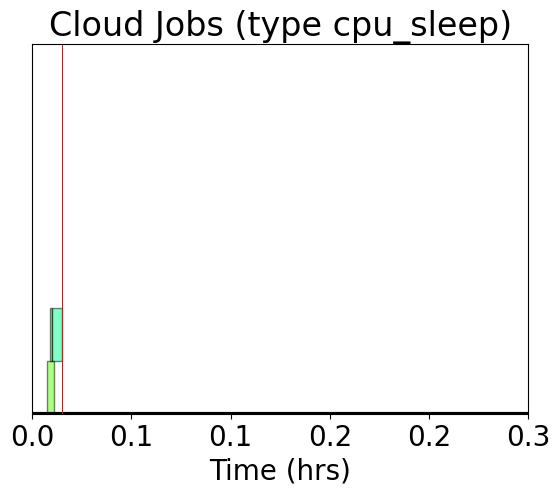

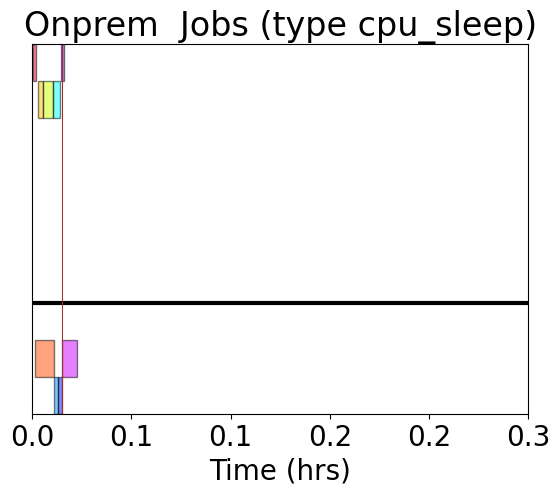

0    None
dtype: object

In [6]:
def index_mapping(jobs=None, gpus_per_node=8, resource='cpu'):
    workload = 'gpu'
    if 'workload_type' in jobs: 
        workload = jobs['workload_type']

    allocated_nodes = jobs['node_index']
    
    if workload == 'gpu':
        cpus = jobs['num_gpus']
    else: 
        cpus = jobs['cpus']
    nodes = set(allocated_nodes)    
    node_jobs ={}
    node_queues = {}
    for node in nodes:
        node_queues[node] = [i + 1 for i in range(gpus_per_node)]
        node_jobs[node] = []

    global_queue = [] # Queue sorted on end time -- earliest to latest end time
    job_id_to_index = {} 

    for i in range(len(jobs['arrival'])):
        #Remove values from queue
        job_id = jobs['idx'][i]
        job_id_to_index[job_id] = i
        job_node = jobs['node_index'][i]
        if workload == 'gpu':
            job_cpu_size = jobs['num_gpus'][i]
        else: 
            job_cpu_size = jobs['cpus'][i]
        job_arrival = jobs['arrival_plot'][i]
        job_runtime = jobs['runtime'][i]
        
        while global_queue and global_queue[0][0] <= job_arrival: 
            end_time, end_job_id = heapq.heappop(global_queue)
            released_index = job_id_to_index[end_job_id]
            for released_node in jobs['allocated_gpus'][released_index]: 
                released_cpus = jobs['allocated_gpus'][released_index][released_node]
                released_node_queue = node_queues[released_node]
                try:
                    node_jobs[released_node].remove(end_job_id)
                except:
                    print("Job Id not found")
                    print(end_job_id)
                    print(node_jobs[released_node])
                    continue
                for cpu in released_cpus:
                    heapq.heappush(released_node_queue, cpu)

        heapq.heappush(global_queue, (job_arrival + job_runtime, job_id))
        job_allocated_cpus = []
        node_queue = node_queues[job_node]
        node_jobs[job_node].append(job_id)
    
        #print(f'job_cpu_size {job_cpu_size}')
        try:
            for j in range(job_cpu_size):
                cpu_index = heapq.heappop(node_queue)
                job_allocated_cpus.append(cpu_index)
        except:
            print(f'Not enough cpus to fit jobs!' + \
                 f'Node Queue: {node_queue}' + \
                 f'Resources Allocated: {job_allocated_cpus}')
        
        jobs['allocated_gpus'][i] = {job_node: job_allocated_cpus}
    return jobs

def generate_gantt_chart(row=None, gpus_per_node=None, ratio=None, scale=None, gpu_jobs=None):
    workload = "gpu"
    if 'workload_type' in row: 
        workload = row['workload_type']
        
    if workload == 'cpu':
        gpus_per_nodes = 2
        
    graphs = ['cloud', 'onprem']
    for graph in graphs:
        save=False; path=None; subplt=None; plt_index=None; tag=None; plot_sweep=False
        varying_values = row['varying_values']
        tag = ""

        count = 0 
        for value in varying_values: 
            tag += str(value)
            tag += ":"
            if isinstance(row[value], str) and len(row[value]) < 50: 
                tag += str(row[value])
            tag += " | "
            count += 1
            if count % 5 == 0: 
                tag += '\n'
                
        gpu_value = 'allocated_gpus'
        fig, ax = plt.subplots()
        row = index_mapping(row, gpus_per_node, 'gpu')
        
        NUM_COLORS = len(row['idx'])
        cm = plt.get_cmap('gist_rainbow')
        colors = [cm(1. * i / NUM_COLORS) for i in range(NUM_COLORS)]

        y_lim_min = 1000
        y_lim_max = -1000
        num_nodes = row['cluster_size'] + row['cluster_size']

        #GPUs equivalent to CPUs -- if no GPU's then GPUS_PER_NODE reflects cpus
        total_gpus = num_nodes * gpus_per_node 
        segment_height_list = {}
        gpu_indices = {}
        gpu_rows = set()
        node_name = ""

        # TODO: Plot infinite cloud spillover 
        try: 
            for j_idx in range(len(row['idx'])):
                allocated_gpus = row[gpu_value][j_idx]
                segment = (row['arrival_plot'][j_idx],
                            row['arrival_plot'][j_idx] + row['runtime'][j_idx], j_idx)

                node_name = row['node'][j_idx]
                if graph == 'onprem' and node_name == 'cloud': 
                    continue
                elif graph == 'cloud' and node_name != 'cloud':
                    continue
                
                #print(f'j_idx {j_idx}')
                
                for node_idx in allocated_gpus.keys():
                    for node_gpu_idx in allocated_gpus[node_idx]:
                        if graph == 'cloud': 
                            gpu_idx = node_gpu_idx
                        else: 
                            gpu_idx = total_gpus - (gpus_per_node * node_idx + node_gpu_idx)
                        #print(f'gpu_idx {gpu_idx}')
                        
                        gpu_rows.add(gpu_idx)
                        gpu_indices[node_name] = [gpu_idx]
                        y_lim_min = min(y_lim_min, gpu_idx)
                        
                        y_lim_max = max(y_lim_max, gpu_idx + 1)
                        if graph == 'cloud':
                            y_lim_max = gpus_per_node

                        plt.barh(gpu_idx,
                                    width=row['runtime'][j_idx],
                                    edgecolor='black',
                                    height=1.0,
                                    left=segment[0],
                                    align='edge',
                                    color=colors[row['idx'][j_idx]] if row['idx'][j_idx] < len(colors) else None,
                                    alpha = 0.5)    
        except Exception as e:
            import traceback
            t = traceback.format_exc()
            print(t)
            print(e)

        for i in range(total_gpus + 1):
            multiplier = math.ceil(num_nodes / 32)
            if (i + 1) % gpus_per_node == 1:
                plt.axhline(y=i + 1, linewidth=3 / multiplier, color='black')
            else:
                pass

        max_arrival = max(row['arrival_plot'])
        completions = [row['arrival_plot'][i] + row['runtime'][i] for i in range(len(row['arrival_plot']))]
        max_completion = max(completions)

        x_lim_max = max_completion
        last_job_time = max(row['completion_time'])

        # TODO: Generalize the plotting functions
        last_job_time= 1000#18405.78506708145#26913
        dim=(y_lim_min, y_lim_max, 0, last_job_time)
        bottom, top, left, right = dim
        plt.ylim(bottom=bottom, top=top)
        plt.xlim(left=left, right=right)
        plt.axvline(x=max_arrival, color='brown', linewidth=0.75)
        plt.xlabel('Time (hrs)')
        plt.ylabel('Nodes ')
        plt.title(str(tag))
        if graph == 'cloud':
            plt.title(f'Cloud Jobs (type {workload})')
        elif graph == 'onprem':
            plt.title(f'Onprem  Jobs (type {workload})')

        gpu_labels = sorted([(v, k) for k, v in gpu_indices.items()])
        ticks = [label[0] for label in gpu_labels]
        ticks = np.array(ticks)
        ticks = ticks.flatten()
        labels = [label[1] for label in gpu_labels]
        labels = np.array(labels)
        labels = labels.flatten()
        plt.yticks(ticks)
        labels = [i for i in range(len(labels))]
        ax.set_yticklabels(labels)
        new_labels = {}
        node_count = 0

        plt.rcParams.update({'font.size': 20})
        plt.tick_params(axis='y', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        ax.set_ylabel('')
        
        def divide(x, pos):
            return '{}'.format(round(x / 3600, 1))

        # Set the formatter
        import matplotlib.ticker as ticker
        formatter = ticker.FuncFormatter(divide)
        ax.xaxis.set_major_formatter(formatter)
        
        if save:
            if path: 
                plt.savefig(path)
                plt.close()
        else:
            plt.show()
        
def remap_cloud_arrival(row):
    new_arrival = [row['start'][i] if row['is_local'][i] == 1 else row['arrival'][i] for i in range(len(row['arrival']))]
    #new_arrival = [1 if row['is_local'] == 1 else 0 for i in range(len(row['arrival']))]
    return new_arrival

jobs_df['arrival_plot'] = jobs_df.apply(remap_cloud_arrival, axis=1)

pd.set_option('display.max_colwidth', None)
display(jobs_df)
pd.reset_option('display.max_colwidth')

for j in range(len(jobs_df)):
    cloud_times = [jobs_df['runtime'][j][i] for i in range(len(jobs_df['runtime'][j])) if jobs_df['is_local'][j][i] == 0  ]
    onprem_times = [jobs_df['runtime'][j][i] for i in range(len(jobs_df['runtime'][j])) if jobs_df['is_local'][j][i] == 1  ]
    print(f'cloud times {cloud_times}\n' + \
          f'onprem times {onprem_times}')

'''
for j in range(len(jobs_df)):
    total_job_arrival = len(jobs_df['arrival'][j])
    total_job_submission = len(jobs_df['start'][j])
    total_job_completion = len(jobs_df['completion_time'][j])
    print(f'{j} {total_job_arrival} {total_job_submission} {total_job_completion}')
'''
    
gpus_per_node = 8 #TODO: Parse this value from the job
ratio = (1, 1)
scale = 1

jobs_df.apply(generate_gantt_chart, axis=1, args=(gpus_per_node, ratio, scale, True))